# Project SSY340
In this notebook we create a costum GAN model to be used for generating sequences of audio. The used data set is https://www.kaggle.com/code/basu369victor/generate-music-with-variational-autoencoder/notebook/, which contains of 1000 samples of audio from 10 different genres. 

## 0.  Imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pathlib import Path
from itertools import chain
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Pre-prosessing

In [43]:
class AudioSample(Dataset):
    """
    Implementing a class for the AudioSample Dataset, inheriting from PyTorch Dataset
    """
    def __init__(self, root, genre_label_dict, duration):
        """
        Initializing an instance with the input data x and corresponding correct labels y.
        """
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")

        self.root = root
        self.genre_label_dict = genre_label_dict
        self.num_classes = len(genre_label_dict) # Store the number of classes for one-hot encoding
        self._samples = self._collect_samples() # Collect samples and store pairs of (filepath, label) in a list
        self.duration = duration

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self._samples)

    def __getitem__(self, index):
        """
        Get sample by index
    
        Args:
            index (int)
    
        Returns:
             The index'th sample (Tensor, int)
        """
        audio_file_path, label = self._samples[index]  # Access the stored path and label for the correct index
        audio_data, _ = librosa.load(audio_file_path, sr=16000, offset=0.0, duration=self.duration)  # Load the audio into memory
        audio_tensor = torch.tensor(audio_data, dtype=torch.float32)  # Convert the audio data into tensor format
    
        min_val = audio_tensor.min()
        max_val = audio_tensor.max()
        audio_tensor = 2 * (audio_tensor - min_val) / (max_val - min_val) - 1  # Scale to [-1, 1]
    
        label_tensor = F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()  # One-hot encode the label
    
        return audio_tensor, label_tensor

    
    def _collect_samples(self):
        """Collect all paths and labels"""

        all_paths_and_labels = []
        
        for genre, label in self.genre_label_dict.items():
            genre_map = genre
            genre_map = Path(genre_map)
            genre_paths = self._collect_audio_sub_dir(self.root / genre_map)

            genre_paths_and_labels = map(lambda path: (path, label), genre_paths)
            all_paths_and_labels.extend(genre_paths_and_labels)

        return sorted(all_paths_and_labels, key=lambda x: x[0].stem)

    @staticmethod
    def _collect_audio_sub_dir(sub_dir: Path):
        """Collect audio paths in a directory"""
        if not sub_dir.exists():
            raise ValueError(
                f"Directory '{sub_dir}' does not exist. Are you sure you have the correct path?"
            )
        return sub_dir.glob("*.wav")

In [44]:
#root = r"c:\Users\JohannaNorell\Documents\GitHub\dml_project\Data\train"
#root = "/Users/fridasjogren/GitHub/dml_project/Data/train"
root = "/home/student/deep-machine-learning/project/data"

#genre_label_dict = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
genre_label_dict = {'classical_4': 0}

duration = 4
audio_train = AudioSample(root, genre_label_dict, duration)

In [45]:
audio_data, label = audio_train[10]
print(f"Sample 0:\n {audio_data}\n label: {label}")
ipd.Audio(audio_data, rate=16000)

Sample 0:
 tensor([ 0.0346, -0.0205, -0.0693,  ...,  0.5177,  0.4941,  0.4565])
 label: tensor([1.])


## 2. Create data loader

In [46]:
batch_size = 64 
num_workers = 4 

#train_root = r"c:\Users\JohannaNorell\Documents\GitHub\dml_project\Data\train"
#val_root = r"c:\Users\JohannaNorell\Documents\GitHub\dml_project\Data\val"

train_root = "/home/student/deep-machine-learning/project/data"
#val_root = "/Users/fridasjogren/GitHub/dml_project/Data/val"

#genre_label_dict = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
genre_label_dict = {'classical_4': 0}

duration = 4
train_dataset = AudioSample(train_root, genre_label_dict, duration)
#val_dataset = AudioSample(val_root, genre_label_dict)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
print(len(train_dataset))

700


## 3.1 Building the GAN-model

In [47]:
# 1st verion of GAN model
# Simple architecture to start with 

class Discriminator(nn.Module):
    def __init__(self, n_inputs=1):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

class Generator(nn.Module):
    def __init__(self, latent_dim, n_outputs):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, n_outputs)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [48]:
# 2nd verion of GAN model
# Added batch normalization
# Increased hidden units

class Discriminator(nn.Module):
    def __init__(self, n_inputs=1):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))  
        return x

class Generator(nn.Module):
    def __init__(self, latent_dim, n_outputs):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, n_outputs)
        self.tanh = nn.Tanh()  

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.tanh(self.fc3(x))  
        return x


In [49]:
# 3rd version of GAN model 
# Added deconvolutional layers in generator

class Discriminator(nn.Module):
    def __init__(self, n_inputs=1):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        print(x.shape)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        #x = self.sigmoid(self.fc3(x))
        x = self.fc3(x) # Wasserstein loss
        return x

class Generator(nn.Module):
    def __init__(self, latent_dim, n_outputs):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256 * 8)  
        self.conv1 = nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)

        self.fc2 = nn.Linear(2048, n_outputs)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = F.relu(self.fc1(x)).view(-1, 256, 8)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = self.tanh(self.fc2(x))
        return x

In [50]:
# 4th version of GAN model 
# Added convolutional layers in discriminator

class Discriminator(nn.Module):
    def __init__(self, n_inputs=1):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        #x = self.sigmoid(self.fc3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x) # Wasserstein loss
        return x

class Generator(nn.Module):
    def __init__(self, latent_dim, n_outputs):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256 * 8)  
        self.conv1 = nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)

        self.fc2 = nn.Linear(2048, n_outputs)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = F.relu(self.fc1(x)).view(-1, 256, 8)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.tanh(self.fc2(x))
        return x

### 3.2 Visualizing the generator and discriminator 

In [30]:
from torchviz import make_dot
import torch

latent_dim = 128

latent_vector = torch.randn(1, latent_dim)  
generated_data = generator(latent_vector)
generator_viz = make_dot(generated_data, params=dict(generator.named_parameters()))
generator_viz.render("generator", format="png") 

audio_input = torch.randn(64, 64000, 1)  
discriminator_output = discriminator(audio_input)
discriminator_viz = make_dot(discriminator_output, params=dict(discriminator.named_parameters()))
discriminator_viz.render("discriminator", format="png")  


'discriminator.png'

## 4. Training

### 4.1 Training loop

In [51]:
#loss_fn = nn.BCELoss()

latent_dim = 128 # Dimension of the noise vector to input to the generator
n_outputs = (duration*16000) # Size of output for both discriminator and generator
generator = Generator(latent_dim, n_outputs)
discriminator = Discriminator(n_outputs)

#learning_rate = 0.001
learning_rate_G = 0.001 # Introduced separate learning rates in order to achieve blanace in training the discriminator and generator 
learning_rate_D = 0.00001
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_G)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate_D)

def train_gan(train_dataloader, num_epochs=20):
    all_D_losses = []
    all_G_losses = []
    for epoch in range(num_epochs):
        for real_audio, _ in train_dataloader: 
            batch_size = real_audio.size(0)
            real_audio = real_audio.view(batch_size, -1)

            #real_labels = torch.ones(batch_size, 1) # Real audio labeled as 1
            #fake_labels = torch.zeros(batch_size, 1) # Fake audio labeled as 0 

            real_labels = torch.ones(batch_size, 1) * 0.9 # Introduced noise to labels in order for discriminator to not be overly confident
            fake_labels = torch.zeros(batch_size, 1) + 0.1
            
            optimizer_D.zero_grad()
            real_outputs = discriminator(real_audio) # Use discriminator for real audio 
            #loss_D_real = loss_fn(real_outputs, real_labels) # Compute loss for real audio
            loss_D_real = real_outputs.sum() # Wasserstein loss

            noise = torch.randn(batch_size, latent_dim) # Initalizing the size of fake audio
            fake_audio = generator(noise) # Generating the fake audio 
            fake_outputs = discriminator(fake_audio) # Classify the fake audio
            #loss_D_fake = loss_fn(fake_outputs, fake_labels) # Compute the fake part of the discriminator loss" 
            loss_D_fake = -fake_outputs.sum() # Wasserstein loss

            #loss_D = loss_D_real + loss_D_fake # Combine real and fake loss
            loss_D = -loss_D_real -loss_D_fake # Wasserstein loss
            loss_D.backward(retain_graph=True) # Backpropagate
            optimizer_D.step()

            for _ in range(2):
                optimizer_G.zero_grad()
                noise = torch.randn(batch_size, latent_dim) # Generate new fake audio
                fake_audio = generator(noise) # Regenerate the fake audio
                fake_outputs = discriminator(fake_audio) # Classify fake audio
                #loss_G = loss_fn(fake_outputs, real_labels) # Compute generator loss
                loss_G = -fake_outputs.sum() # Wasserstein loss
                loss_G.backward() # Backpropagate
                optimizer_G.step()

        # Print progress
        all_D_losses.append(loss_D.item())
        all_G_losses.append(loss_G.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_D.item()}, Loss G: {loss_G.item()}')

    return all_D_losses, all_G_losses

d_losses, g_losses = train_gan(train_dataloader, num_epochs=100)

Epoch [1/100], Loss D: 0.1916753053665161, Loss G: -0.802861750125885
Epoch [2/100], Loss D: -3.187894344329834, Loss G: -0.5764222741127014
Epoch [3/100], Loss D: -4.9126434326171875, Loss G: -1.3916370868682861
Epoch [4/100], Loss D: -6.438982009887695, Loss G: -2.2296807765960693
Epoch [5/100], Loss D: -4.816027641296387, Loss G: -4.873589515686035
Epoch [6/100], Loss D: -4.758319854736328, Loss G: -8.885773658752441
Epoch [7/100], Loss D: 1.2926340103149414, Loss G: -16.59311866760254
Epoch [8/100], Loss D: 7.05085563659668, Loss G: -20.72292709350586
Epoch [9/100], Loss D: 11.708097457885742, Loss G: -23.30826759338379
Epoch [10/100], Loss D: 5.397817611694336, Loss G: -19.732925415039062
Epoch [11/100], Loss D: 6.597631454467773, Loss G: -24.691028594970703
Epoch [12/100], Loss D: 4.004751205444336, Loss G: -28.044109344482422
Epoch [13/100], Loss D: 4.528068542480469, Loss G: -25.229875564575195
Epoch [14/100], Loss D: 3.2712764739990234, Loss G: -21.017026901245117
Epoch [15/10

### 4.2 Visualize the discriminator and generator loss

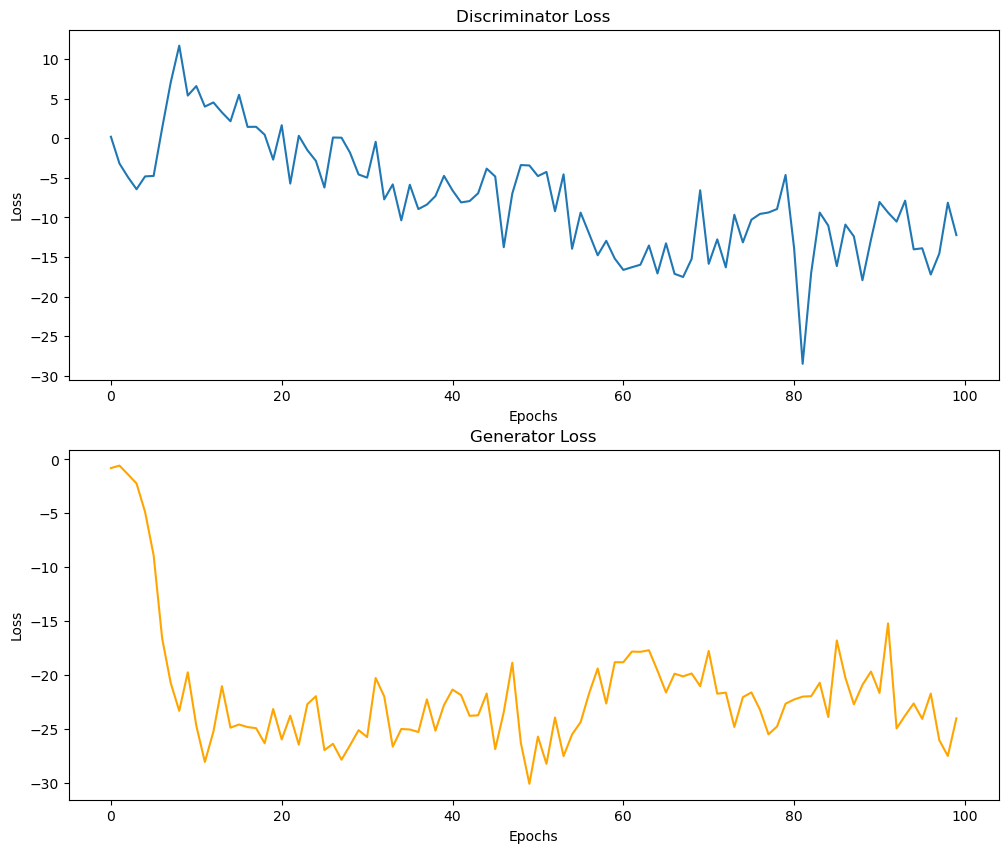

In [52]:
fig, axs = plt.subplots(2, 1, figsize = (12,10))

axs[0].plot(d_losses, label = "Discriminator Loss")
axs[1].plot(g_losses, label = "Generator Loss", color = "orange")

axs[0].set_xlabel("Epochs")
axs[1].set_xlabel("Epochs")

axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Loss")

axs[0].set_title("Discriminator Loss")
axs[1].set_title("Generator Loss")
plt.show()

### 4.3 Generated audio

In [55]:
# Listen to generated audio
def generate_audio_sample(generator, latent_dim, duration=4, sample_rate=16000):
    
    generator.eval()
    noise = torch.randn(1, latent_dim)  

    with torch.no_grad():
        generated_audio = generator(noise)

    generated_audio = generated_audio.view(-1).cpu().numpy()
    generated_audio = generated_audio / np.max(np.abs(generated_audio))

    return Audio(generated_audio, rate=sample_rate)

generated_audio = generate_audio_sample(generator, latent_dim)
generated_audio